


<font size='10' color = 'E3A440'>**Megadata and Advanced Techniques Demystified**</font>
=======
<font color = 'E3A440'>*New Analysis Methods and their Implications for Megadata Management in SSH (part 2)*</font>
=============


This workshop is part of the training [Megadata and Advanced Techniques Demystified](https://www.4point0.ca/en/2022/08/22/formation-megadonnees-demystifiees//) (session 6).

Humanities and social sciences are often confronted with the analysis of unstructured data, such as text. After preparing the data, several analysis techniques from machine learning can be used. During this workshop, participants will be introduced to the preprocessing of textual data and to supervised and unsupervised methods for analysis purposes with Python.


Structure of the workshop :
1. Part 1 : Examples of supervised and unsupervised methods for text mining
2. Part 2 : Exercices

### Autors: 
- Bruno Agard <bruno.agard@polymtl.ca>
- Davide Pulizzotto <davide.pulizzotto@polymtl.ca>

Département de Mathématiques et de génie industriel

École Polytechnique de Montréal

# <font color = 'E3A440'>0. Preparation environnement </font>

In [ ]:
# Downloading of data from the GitHub project
!rm -rf Data_techniques_demystified_webinars/
!git clone https://github.com/4point0-ChairInnovation-Polymtl/Data_techniques_demystified_webinars

In [ ]:
# Import modules
import os
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

<a name='Section_1'></a>
# <font color = 'E3A440'>1. *Preparation of textual data* (Reminders)</font>

The pre-processing of a corpus of texts may require the implementation of several steps including: the splitting of sentences, words, cleaning, filtering, etc.

In the next blocks of code, a text will be segmented into sentences and preprocessed using the `CleaningText()` function prepared in the previous session (October 27th, 2022).



In [ ]:
text = """At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.
This morning, Arthur is feeling better.
A dog runs in the street.
A little boy in running in the street.
Arthur is my dog, he sleeps every morning."""

In [ ]:
# extraction of sentences
sentences = nltk.sent_tokenize(text)
print(sentences)

["At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.", 'This morning, Arthur is feeling better.', 'A dog runs in the street.', 'A little boy in running in the street.', 'Arthur is my dog, he sleeps every morning.']


In [ ]:
# Cleaning fonction to preprocess text
def CleaningText(text_as_string, language = 'english', reduce = '', list_pos_to_keep = [], Stopwords_to_add = []):
    from nltk.corpus import stopwords

    words = nltk.word_tokenize(text_as_string)
    words_pos = nltk.pos_tag(words, tagset='universal')
    words_pos = [(w, pos) for w, pos in words_pos if w.isalnum()]
    words_pos = [(w.lower(), pos) for w, pos in words_pos]
    
    if reduce == 'stem': 
        from nltk.stem.porter import PorterStemmer
        reduced_words_pos = [(PorterStemmer().stem(w), pos) for w, pos in words_pos]
        
    elif reduce == 'lemma':
        from nltk.stem.wordnet import WordNetLemmatizer
        reduced_words_pos = [(WordNetLemmatizer().lemmatize(w), pos) for w, pos in words_pos]
    else:
        import warnings
        reduced_words_pos = words_pos
        warnings.warn("Warning : any reduction was made on words! Please, use \"reduce\" argument to chosse between 'stem' or  'lemma'")
    if list_pos_to_keep:
        reduced_words_pos = [(w, pos) for w, pos in reduced_words_pos if pos in list_pos_to_keep]
    else:
        import warnings
        warnings.warn("Warning : any POS filtering was made. Please, use \"list_pos_to_keep\" to create a list of POS tag to keep.")
    
    list_stopwords = stopwords.words(language) + Stopwords_to_add
    reduced_words_pos = [(w, pos) for w, pos in reduced_words_pos if w not in list_stopwords and len(w) > 1 ]
    return reduced_words_pos   

In [ ]:
# Cleaning of sentences and selection of POS tags
cleaned_sentences = [CleaningText(sent, reduce = 'stem', list_pos_to_keep = ['NOUN','ADJ','VERB']) for sent in sentences]
print(cleaned_sentences)

[[('thursday', 'NOUN'), ('morn', 'NOUN'), ('great', 'ADJ'), ('arthur', 'NOUN'), ('feel', 'VERB'), ('good', 'ADJ')], [('morn', 'NOUN'), ('arthur', 'NOUN'), ('feel', 'VERB')], [('dog', 'NOUN'), ('run', 'VERB'), ('street', 'NOUN')], [('littl', 'ADJ'), ('boy', 'NOUN'), ('run', 'VERB'), ('street', 'NOUN')], [('arthur', 'NOUN'), ('dog', 'NOUN'), ('sleep', 'VERB'), ('morn', 'NOUN')]]


Following, the list of POS tags

| **POS** | **DESCRIPTION**           | **EXAMPLES**                                      |
| ------- | ------------------------- | ------------------------------------------------- |
| ADJ     | adjective                 | big, old, green, incomprehensible, first      |
| ADP     | adposition                | in, to, during                                |
| ADV     | adverb                    | very, tomorrow, down, where, there            |
| AUX     | auxiliary                 | is, has (done), will (do), should (do)        |
| CONJ    | conjunction               | and, or, but                                  |
| CCONJ   | coordinating conjunction  | and, or, but                                  |
| DET     | determiner                | a, an, the                                    |
| INTJ    | interjection              | psst, ouch, bravo, hello                      |
| NOUN    | noun                      | girl, cat, tree, air, beauty                  |
| NUM     | numeral                   | 1, 2017, one, seventy-seven, IV, MMXIV        |
| PART    | particle                  | ’s, not                                      |
| PRON    | pronoun                   | I, you, he, she, myself, themselves, somebody |
| PROPN   | proper noun               | Mary, John, London, NATO, HBO                 |
| PUNCT   | punctuation               | ., (, ), ?                                    |
| SCONJ   | subordinating conjunction | if, while, that                               |
| SYM     | symbol                    | $, %, §, ©, +, −, ×, ÷, =, :)               |
| VERB    | verb                      | run, runs, running, eat, ate, eating          |
| X       | other                     | sfpksdpsxmsa                                  |
| SPACE   | space                     |                                                   |

# <font color = 'E3A440'>*2. Vectorization* (Reminders)</font>

Typically, to use text in a data analysis or machine learning context, text must be transformed into an appropriate mathematical object.
The simplest and most widespread model is the "bags-of-words", in which each text (or each text fragment) is defined in a vector, by a certain number of lexical units which characterize it. This model belongs to the family of vector semantics models and it has the following form:


$$X = \begin{bmatrix} 
x_{1,1} & x_{1,2} & \ldots & x_{1,w} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
x_{n,1} & x_{1,2} & \ldots & x_{n,w} \\
\end{bmatrix}
$$ 

In this matrix, the value $x_{i,j}$ represents the "weigth" of the word $j$ in the text fragment $i$. This weigth can be computed in several way. Thus :

- $x_{i,j}$ can represents the presence of the word "j" in text fragment $i$,
- $x_{i,j}$ can measures the quantoty of occurrences of a word $j$ in text fragment $i$,
- $x_{i,j}$ can represent the **value** of the word $j$ in text fragment $i$, and this, using metric such as tf-idf :
 $$\text{tf-idf}_{i,j}=\text{tf}_{i,j}.log\left(\frac{n}{n_i}\right)$$
 - $\text{tf}_{i,j}$ is the frequency of word $i$ in text fragment $j$,
 - $n$ total count of text fragments,
 - $n_i$ total counts of text fragments containing the word $i$.


Pay attention to the following arguments of the `CountVectorizer()` function:

 1.   `min_df`: the minimum documentary frequency that a word must respect to be retained in the matrix
 2.   `max_df`: the maximum documentary frequency that a word must respect to be retained in the matrix
 3,   `ngram_range`: allows to add the n-grams (bigrams, trigrams, etc.) to the vectorization

In [ ]:
# Object initialization
from nltk.corpus import stopwords

def identity_tokenizer(text):
    return text

# Transforming the word in frequencies
vectorized = CountVectorizer(lowercase = False, # Convert all characters to lowercase before tokenizing
                             min_df = 1, # Ignore terms that have a document frequency strictly lower than the given threshold 
                             max_df = 10, # Ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
                             stop_words = stopwords.words('english'), # Remove the list of words provided
                             ngram_range = (1, 1), # Get the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted
                             tokenizer=identity_tokenizer) # Override the string tokenization step while preserving the preprocessing and n-grams generation steps

Use of the "vectorizer" with a list of word lists (and not a list of word-pos tuples) and creation of the frequency weighting matrix.

In [ ]:
# Application du vectorizer
freq_term_DTM = vectorized.fit_transform([[w for w, pos in sent] for sent in cleaned_sentences])

freq_Matrix=pd.DataFrame(freq_term_DTM.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(freq_Matrix)

Thus, we assign the result of the Tf-IDF weighting to the variable named `tfidf_DTM`. 

In [ ]:
# Calculate the tfidf matrix
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM = tfidf.fit_transform(freq_term_DTM)

tfidf_Matrix=pd.DataFrame(tfidf_DTM.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(tfidf_Matrix)


# <font color = 'E3A440'>3.0. Segmentation </font>

The purpose of segmentation is to divide a data set into smaller subsets that share certain characteristics.

We want the elements within the same subgroup to be as similar as possible.

A large majority of segmentation methods are then based on distance metrics.


### <font color = 'E3A440'>3.1. Distance metrics </font>




#### <font color = 'E3A440'>3.1.1. Distance between points </font>

There are many metrics to evaluate the similarity/distance between two points:


### Euclidean Distance

$$d(x_1,x_2) = \sqrt{\sum_i^n\left(x_{1,i},x_{2,i}\right)^2}$$


### Hamming Distance

In number of different coordinates

$$d_1(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    0,\ if\ x_{1,i} = x_{2,i}\\
    Sinon\ 1\\
    \end{cases}
\end{split}


In number of different "positive" coordinates

$$d_2(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    0,\ if\ x_{1,i} = x_{2,i} = 1\\
    Sinon\ 1\\
    \end{cases}
\end{split}

As a percentage of different "positive" coordinates

$$d_3(x_1,x_2) = \frac{d_1(x_1,x_2)\ ou\ d_2(x_1,x_2)}{n}$$

With different possible weightings

$$d_4(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    p,\ if\ x_{1,i} = x_{2,i} = 1\\
    1,\ if\ x_{1,i} = x_{2,i} = 0\\ 
    Sinon\ 0\\
    \end{cases}
\end{split}

There are other 'adapted' versions of Hamming...


### Many more ...

But none really does what you'll need, because your need is unique.





#### <font color = 'E3A440'>3.1.2. Hypermetrics, distances between groups </font>

 - Nearest neighbor (single linkage)
 - Farthest neighbor (complete linkage)
 - Average distance (average linkage)
 - Distance to the center of gravity
 - ...




### <font color = 'E3A440'>3.2. Data normalisation </font>

For distance-based algorithms, it is important to normalize the data:

In [ ]:
from scipy.spatial import distance

X = np.array([[100000, 0, 0, 0, 0, 0, 0],
              [100000, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1],
             ])

print(X)

[[100000      0      0      0      0      0      0]
 [100000      1      1      1      1      1      1]
 [     1      1      1      1      1      1      1]]


In [ ]:
print( distance.euclidean(X[0], X[1]) )
print( distance.euclidean(X[1], X[2]) )

2.449489742783178
99999.0


#### Decimal normalization

In [ ]:
XD=X.copy()
XD[:, 0] = XD[:, 0]/100000

print(XD)

[[1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1]]


In [ ]:
print( distance.euclidean(XD[0], XD[1]) )
print( distance.euclidean(XD[1], XD[2]) )

2.449489742783178
1.0


#### Min/max Normalisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

XmM=X.copy()
scaler = MinMaxScaler().fit(XmM)
XmM=scaler.transform(XmM)
#X=scaler.inverse_transform(X)

print(XmM)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]]


In [ ]:
print( distance.euclidean(XmM[0], XmM[1]) )
print( distance.euclidean(XmM[1], XmM[2]) )

2.449489742783178
1.0


#### Normalization on variance

In [ ]:
from sklearn.preprocessing import StandardScaler

XV=X.copy()
scaler = StandardScaler().fit(XV)
XV=scaler.transform(XV)
#X=scaler.inverse_transform(X)

print(XV)

[[ 0.70710678 -1.41421356 -1.41421356 -1.41421356 -1.41421356 -1.41421356
  -1.41421356]
 [ 0.70710678  0.70710678  0.70710678  0.70710678  0.70710678  0.70710678
   0.70710678]
 [-1.41421356  0.70710678  0.70710678  0.70710678  0.70710678  0.70710678
   0.70710678]]


In [ ]:
print( distance.euclidean(XV[0], XV[1]) )
print( distance.euclidean(XV[1], XV[2]) )

5.196152422706631
2.1213203435596424


### <font color = 'E3A440'>3.3. Segmentation algorithms </font>

There are many algorithms to achieve the segmentation of a data set. We choose a particular algorithm according to the type of data and the type of result we are looking for.

In [ ]:
# Draw fonction to plot results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import unique
from numpy import where

def draw(X,yhat):
    # retrieve unique clusters
    clusters = unique(yhat)

    #plt.figure(figsize=(10, 10))
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])

    plt.title("Clusters")
    # show the plot
    plt.show() 

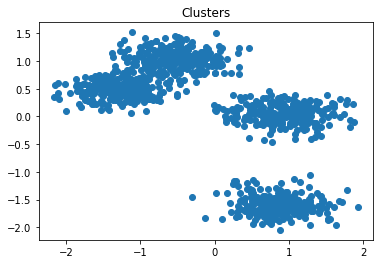

In [ ]:
#dataset generator
k=4
n_samples=1000
features=3

# define dataset
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

X, _ = make_blobs(n_samples, centers=k, n_features=features, cluster_std=0.6, random_state=0)

scaler = StandardScaler().fit(X)
X=scaler.transform(X)
#X=scaler.inverse_transform(X)

yhat=np.zeros(n_samples)
    
draw(X,yhat)

#### <font color = 'E3A440'>3.3.1. k-means</font>
Applying a <font color='E3A440'>**segmentation**</font> algorithm to a database makes it possible to segment observations into homogeneous groups of data.

To do this, the objective of the k-means algorithm is to minimize the intra-class inertia around a centroid of each group. For k-means, the centroid of each group is the mean of that group. Centroids are updated at each iteration during training.

The k-means method generates a vector $Y$ of size $n$, which contains the <font color='E3A440'>**group labels**</font> assigned to each observation. Labels can range from $0$ to $k$. $k$ is the parameter that allows the user to determine the number of groups to generate.

$$
Y = \begin{bmatrix} 
c_1 \\
c_2 \\
\vdots \\ 
c_n
\end{bmatrix}$$

$Y_i$ corresponds to the group assigned to $X_i$.

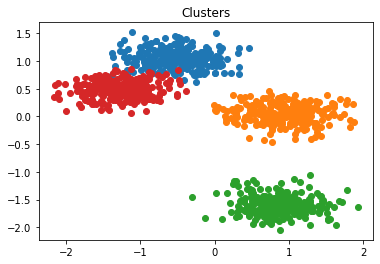

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4).fit(X)

# assign a cluster to each example
yhatkm = model.predict(X)

draw(X,yhatkm)

##### What happens at each iteration?

The algorithm performs the following steps:
 1. **Initialization of centroid**: k points (*k* is chosen by the user) are randomly selected from the data set. Each of these points will be used as a centroid of a group for the first iteration. Each centroid will wear the label of the group he represents.
 
 2. **Start of iterations**:

   2.1. **Classification**: Assign each point in the data set the label of the centroid closest to it.

   2.2. **centroid update**: For each generated group, calculate the "center" of the data associated with the group. This center will be the new centroid for the group.

   2.3. **Repetition**: Repeat operations 2.1. and 2.2. up to a stopping criterion (stabilization of the centroids, number of iterations, calculation time, etc.).

Iteration : 1


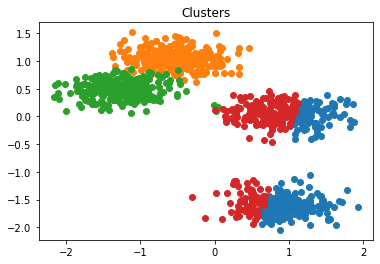

Iteration : 2


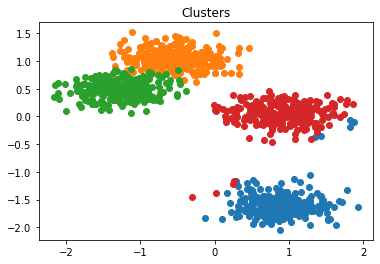

Iteration : 3


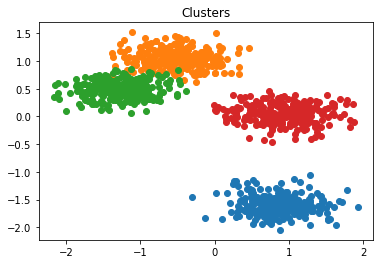

...
...
...

Iteration : 10


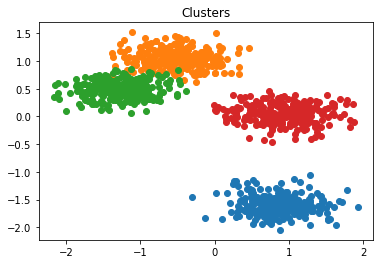

In [ ]:
k=4

for i in range (1,4) :
    print("Iteration :", i)
    model = KMeans(n_clusters=k, max_iter=i, n_init=1, init="random", random_state=1).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

print("...\n...\n...\n")

i=10
print("Iteration :", i)
model = KMeans(n_clusters=k, max_iter=i, n_init=1, init="random", random_state=1).fit(X)
# assign a cluster to each example
yhatkm = model.predict(X)
draw(X,yhatkm)

##### Initialization Sensitivity

Random state : 1


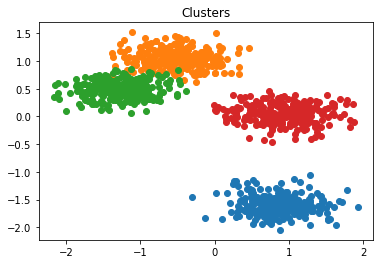

Random state : 2


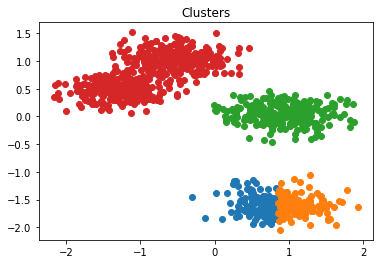

Random state : 3


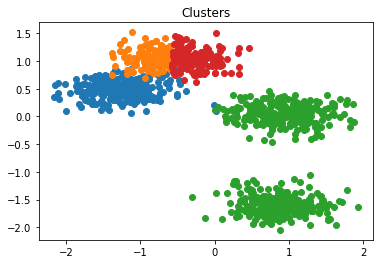

Random state : 4


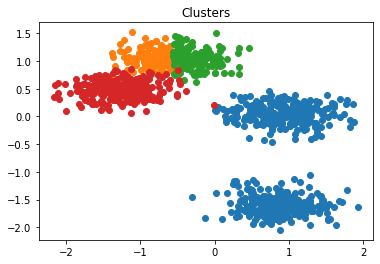

Random state : 5


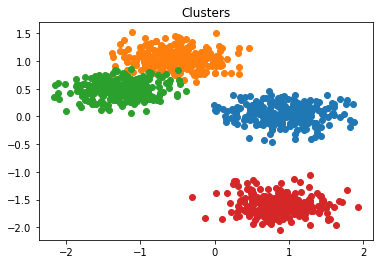

In [ ]:
for rs in range (1,6) :
    print("Random state :", rs)
    model = KMeans(n_clusters=k, n_init=1, init="random", random_state=rs).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

Findings:

 - K-means is sensitive to the initial choice of centroids, this algorithm gives a LOCAL optimum.
 
 - The initialization has an impact on the results of the k-means, therefore on the quality of the partitioning.

 - To compensate, we can:
 
     - carefully choose the initialization points according to our knowledge of the problem,

     - apply k-means with different starting points and keep the best result,
         
     - apply specific initialization methods, among which there is *k-means++*.

##### Sensitivity to the number of groups

The *k* parameter determines the number of groups desired. The method is very sensitive to this parameter, and it must be chosen wisely.

k =  1


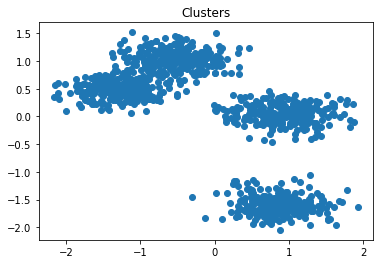

k =  2


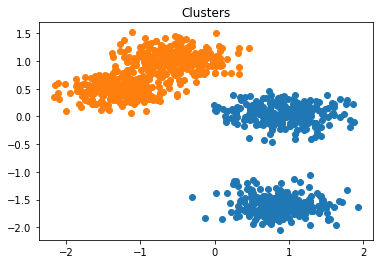

k =  3


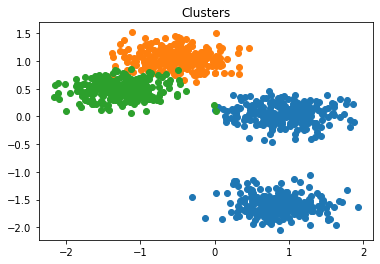

k =  4


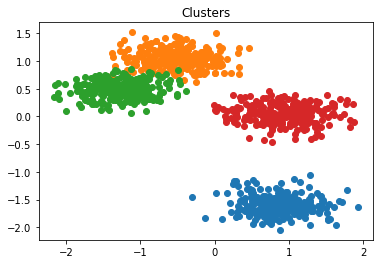

k =  5


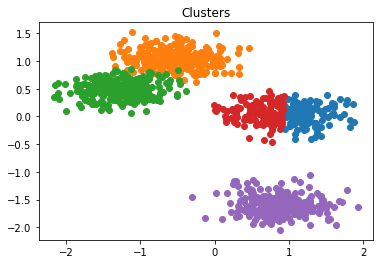

In [ ]:
for m in range (1,6) :
    print("k = ", m)
    model = KMeans(n_clusters=m, max_iter=20, n_init=1, init="random", random_state=1).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

Conclusion :

  - the wrong number of groups can result in groups that do not make sense for the purpose of the analysis.

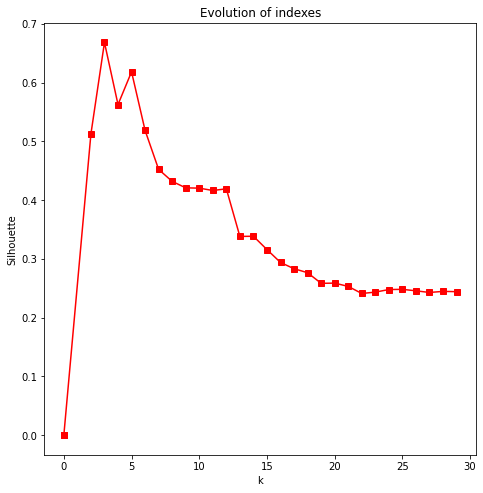

In [ ]:
from sklearn.metrics import silhouette_score

max=30
Sil=np.zeros(max)
x_axis=np.zeros(max)

for m in range (2,max) :

    model = KMeans(n_clusters=m, max_iter=100, n_init=1, init="random", random_state=3).fit(X)

    # assign a cluster to each example
    labels = model.predict(X)

    Sil[m]=silhouette_score(X, labels, metric="euclidean")
    x_axis[m]=m

fig = plt.figure(figsize=(6, 6))
a1 = fig.add_axes([0,0,1,1])
l1 = a1.plot(x_axis,Sil,'rs-') # solid line with yellow colour and square marker
a1.set_xlabel('k')
a1.set_ylabel('Silhouette')
a1.set_title('Evolution of indexes')
plt.show()

##### From our set of texts

In [ ]:
print(text)

At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.
This morning, Arthur is feeling better.
A dog runs in the street.
A little boy in running in the street.
Arthur is my dog, he sleeps every morning.


In [ ]:
tfidf_Matrix=tfidf_DTM.toarray()

model = KMeans(n_clusters=2).fit(tfidf_Matrix)

# assign a cluster to each example
yhatkm_tfidf = model.predict(tfidf_Matrix)

print(yhatkm_tfidf)

[0 0 1 1 0]


#### <font color = 'E3A440'>3.3.2. Hiéarchical Clustering</font>




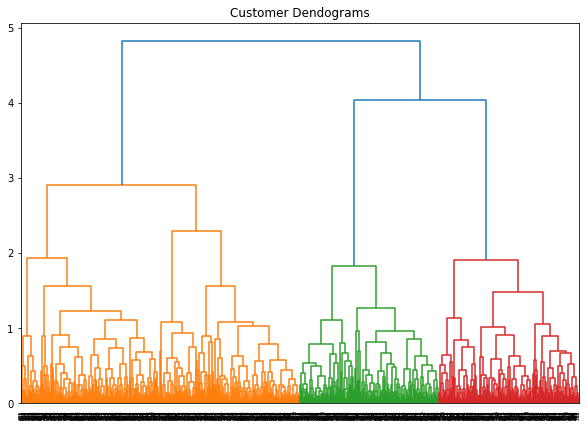

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, metric='euclidean', method='complete'))
plt.show()

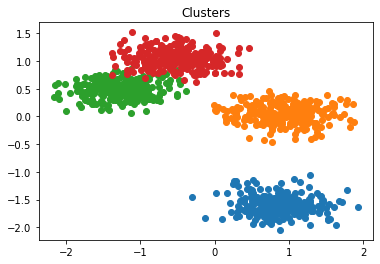

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model=AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete').fit(X)
#{“ward”, “complete”, “average”, “single”},

# assign a cluster to each example
yhatac=model.fit_predict(X)

draw(X,yhatac)

##### From our set of texts

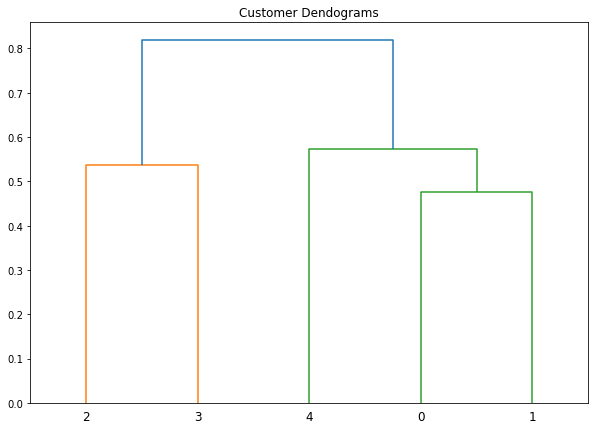

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(tfidf_Matrix, metric='euclidean', method='complete'))
plt.show()

#### <font color = 'E3A440'>3.3.3. DBSCAN</font>

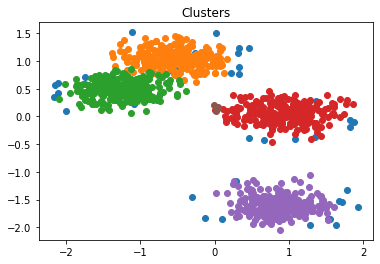

In [ ]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.2, min_samples=4, metric="euclidean").fit(X)

# assign a cluster to each example
yhatdbs=model.fit_predict(X)

draw(X,yhatdbs)

#### <font color = 'E3A440'>3.3.4. Analysis of group content</font>

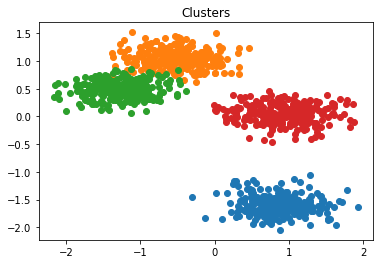

Silhouette= 0.721826710101402


In [ ]:
model = KMeans(n_clusters=4, max_iter=20, n_init=1, init="random", random_state=1).fit(X)

# assign a cluster to each example
labels = model.predict(X)

draw(X,labels)

print("Silhouette=", silhouette_score(X, labels, metric="euclidean"))

In [ ]:
clusters = unique(yhatkm)

for cluster in clusters:
    C = X[yhatkm[:] == cluster]
    labels=yhatkm[yhatkm[:] == cluster]
    print('Cluster %1.0f : size = %.0f' % (cluster, len(C)))

Cluster 0 : size = 120
Cluster 1 : size = 250
Cluster 2 : size = 250
Cluster 3 : size = 130
Cluster 4 : size = 250


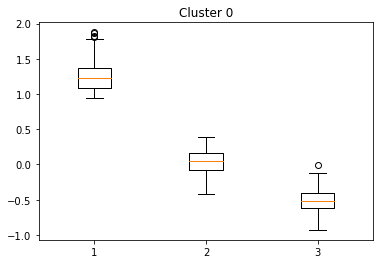

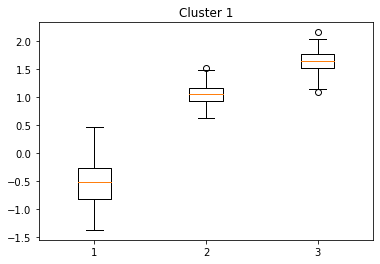

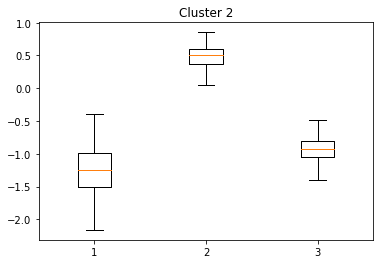

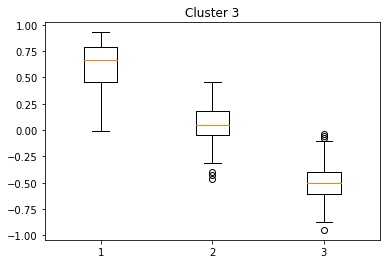

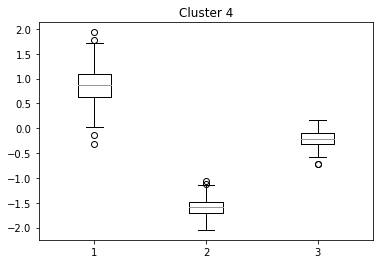

In [ ]:
for cluster in clusters:
    C = X[yhatkm[:] == cluster]
    fig1, ax1 = plt.subplots()
    ax1.set_title('Cluster %1.0f' % (cluster))
    ax1.boxplot(C);

# <font color = 'E3A440'>4. Supervised methods</font>




## <font color = 'E3A440'>4.1. Multilayer perceptron</font>

Before going on, it is necessary to prepare the corpus.

In [ ]:
text2="""At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.
This morning, at nine o'clock, Arthur is feeling better.
A dog runs in the street.
In my city, cats run in the street.
A little boy is running in the street.
Arthur is my dog, we love to walk in the street together."""

In [ ]:
# Clean
sentences2 = nltk.sent_tokenize(text2)
cleaned_sentences2 = [CleaningText(sent, reduce = 'stem', list_pos_to_keep = ['NOUN','ADJ','VERB']) for sent in sentences2]

# Calculate the tfidf matrix
freq_term_DTM2 = vectorized.fit_transform([[w for w, pos in sent] for sent in cleaned_sentences2])
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM2 = tfidf.fit_transform(freq_term_DTM2)

# convert in Dataframe for pedagogical reason
tfidf_Matrix2 = pd.DataFrame(tfidf_DTM2.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
tfidf_Array2 = tfidf_DTM2.toarray()
print(tfidf_Matrix2)


     arthur       boy       cat      citi       dog      feel      good  \
0  0.129833  0.000000  0.000000  0.000000  0.000000  0.153781  0.187535   
1  0.296832  0.000000  0.000000  0.000000  0.000000  0.351584  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.389447  0.000000  0.000000   
3  0.000000  0.000000  0.304361  0.304361  0.000000  0.000000  0.000000   
4  0.000000  0.304361  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.168627  0.000000  0.000000  0.000000  0.199731  0.000000  0.000000   

      great     littl      love      morn       run    street  thursday  \
0  0.187535  0.000000  0.000000  0.153781  0.000000  0.000000  0.187535   
1  0.000000  0.000000  0.000000  0.351584  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.328798  0.281755  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.210713  0.180565  0.000000   
4  0.000000  0.304361  0.000000  0.000000  0.210713  0.180565  0.000000   
5  0.000000  0.000000  0

### <font color = 'E3A440'>4.1.1. Preparation of the training and test corpus</font>

To execute a supervised method, it is necessary to obtain a training corpus and a test corpus.

In [ ]:
from sklearn.neural_network import MLPClassifier

#split the data
X_train, X_test = tfidf_Array2[:5,:], tfidf_Array2[5:,:]
y_train, y_test = [1,1,2,2,2],[2]

### <font color = 'E3A440'>4.1.2. Training</font>

In the next chunck of code, the algorithm is first initialized.

Then the `.ft()` method is used to run the training. `.fit()` requires `X_train` (training corpus) and `y_train` (the list of tags for the training corpus).

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=5, learning_rate="constant", learning_rate_init=0.01)
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=5, learning_rate_init=0.01, max_iter=300,
              random_state=1)

### <font color = 'E3A440'>4.1.3. Model evaluation</font>

The variables `y_valid`, which allows to evaluate the learing error rate, and `y_pred`, which allows to evaluate the prediction error rate, are generated in the following chunck of code.

In [ ]:
y_valid = clf.predict(X_train)
y_pred = clf.predict(X_test)

The `accuracy_score()` function calculates the evaluation metric, which is the **accuracy**.

In [ ]:
from sklearn.metrics import accuracy_score

print("Learning errors")
print("    Accuracy = ", accuracy_score(y_train, y_valid)*100)

print("\nPrediction errors")
print("    Accuracy = ", accuracy_score(y_test, y_pred)*100)

Learning errors
    Accuracy =  100.0

Prediction errors
    Accuracy =  100.0


In [ ]:
from sklearn.metrics import confusion_matrix

print("\n** Learning performances: **") 
print("Confusion Matrix: ") 
print(confusion_matrix(y_train, y_valid))
print ("Accuracy : ", accuracy_score(y_train, y_valid)*100) 
print("** Prediction performances: **") 
print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred))
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 


** Learning performances: **
Confusion Matrix: 
[[2 0]
 [0 3]]
Accuracy :  100.0
** Prediction performances: **
Confusion Matrix: 
[[1]]
Accuracy :  100.0


# <font color = 'E3A440'>5. Exercise: Analysis of the database 20 Newsgroups</font>

The `20 Newsgroups` database is a collection of approximately 20,000 documents segmented into more or less 20 different subject areas.

The data are downloaded from the `sklearn.datasets` module and reorganized in tabular format. For pedagogical reasons, this exercise foresees the use of a sample of approximately 3,000 documents segmented into 3 different groups:
 1. `rec.autos`, identified with the value `7` in the `target` column
 2. `rec.sport.hockey`, identified with the value `10` in the `target` column
 3. `sci.med`, identified with the value `13` in the `target` column

During the exercise, the participant will be prompted to fill in the missing parts of the code which are indicated with `...` (three dots).

In [ ]:
from sklearn.datasets import fetch_20newsgroups
archive20newsgroup = fetch_20newsgroups(subset = 'all')
df = pd.DataFrame({'Text': archive20newsgroup.data, 'target': archive20newsgroup.target})
target_names = archive20newsgroup.target_names
print(target_names)

# subset selection
target_selected = [7,10,13]
df = df[df.target.isin(target_selected)]
target_names = [x for idx, x in enumerate(target_names) if idx in target_selected]
print(target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
['rec.autos', 'rec.sport.hockey', 'sci.med']


The sample of the database contains 2,979 documents, segmented into 3 themes.

In [ ]:
df.shape

(2979, 2)

Here are the available variable names.

In [ ]:
df.columns

Index(['Text', 'target'], dtype='object')

Here is an observation (a row of the data table):

In [ ]:
df.iloc[284].Text

"From: yozzo@watson.ibm.com (Ralph Yozzo)\nSubject: Cold Sore Location?\nDisclaimer: This posting represents the poster's views, not necessarily those of IBM.\nNntp-Posting-Host: king-arthur.watson.ibm.com\nOrganization: IBM T.J. Watson Research Center\nLines: 11\n\nI've had cold sores in the past.  But they have always been in the \ncorner of my mouth.  Recently,  I've had what appears to be\na cold sore, but on my lower lip in the middle (above the chin).\n\nCan cold sores appear anywhere around the mouth (or body)?\n\nIs there a medical term for cold sore?\n\n-- \n Ralph Yozzo (yozzo@watson.ibm.com)  \n From the beautiful and historic New York State Mid-Hudson Valley.\n"

## <font color = 'E3A440'>5.1 Exercise presentation </font>

The exercise consists of two parts:

 1. Fill in the missing parts of code (indicated with the `...`)
 2. Change preprocessing parameters to experiment the impacts they may have on unsupervised and supervised methods. In particular, you are invited to experiment the following operations:

    2.1. Choose a different selection of POS tags (`CleaningText()` function)

    2.2. Eliminate words of your choice by adding them to the stopword list (`CleaningText()` function)

    2.3. Change the minimum frequency threshold to retain a word in the matrix (`CountVectorizer()` function)

    2.4 Add bigrams and trigrams during vectorization (`CountVectorizer()` function)



If you want to go further, you could also change the parameters of the unsupervised and supervised algorithms to analyze the impacts on the results.


Rappel: voici la liste de POS tag existant.

| **POS** | **DESCRIPTION**           | **EXAMPLES**                                      |
| ------- | ------------------------- | ------------------------------------------------- |
| ADJ     | adjective                 | big, old, green, incomprehensible, first      |
| ADP     | adposition                | in, to, during                                |
| ADV     | adverb                    | very, tomorrow, down, where, there            |
| AUX     | auxiliary                 | is, has (done), will (do), should (do)        |
| CONJ    | conjunction               | and, or, but                                  |
| CCONJ   | coordinating conjunction  | and, or, but                                  |
| DET     | determiner                | a, an, the                                    |
| INTJ    | interjection              | psst, ouch, bravo, hello                      |
| NOUN    | noun                      | girl, cat, tree, air, beauty                  |
| NUM     | numeral                   | 1, 2017, one, seventy-seven, IV, MMXIV        |
| PART    | particle                  | ’s, not                                      |
| PRON    | pronoun                   | I, you, he, she, myself, themselves, somebody |
| PROPN   | proper noun               | Mary, John, London, NATO, HBO                 |
| PUNCT   | punctuation               | ., (, ), ?                                    |
| SCONJ   | subordinating conjunction | if, while, that                               |
| SYM     | symbol                    | $, %, §, ©, +, −, ×, ÷, =, :)               |
| VERB    | verb                      | run, runs, running, eat, ate, eating          |
| X       | other                     | sfpksdpsxmsa                                  |
| SPACE   | space                     |                                                   |

### <font color = 'E3A440'> a. Construction of some functions that will be used later</font>


In [ ]:
def plot_data_by_cluster(DTM, cls_kmeans, figsize = (16,10) ):
    ## Reduction of dimension to 2 for visualisation reasons
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import time
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,metric='cosine', learning_rate=10, random_state = 794)
    reduc_dim_results = tsne.fit_transform(DTM)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    ## Create data structure for plotting
    df_reduction = pd.DataFrame()
    df_reduction['y'] =  cls_kmeans.labels_
    df_reduction['1-dim'] = reduc_dim_results[:,0]
    df_reduction['2-dim'] = reduc_dim_results[:,1]

    ## Generate the plot
    import seaborn as sns
    import colorcet as cc
    plt.figure(figsize = figsize)
    sns.scatterplot(data = df_reduction,
                    x="1-dim",
                    y="2-dim",
                    hue="y",
                    palette = sns.color_palette(cc.glasbey, n_colors = cls_kmeans.n_clusters),)

    plt.show()

def prepare_data_for_WC(DTM, vocabulary_dtm):
    import scipy
    # compute total frequency for each word
    values_words = sum(DTM)
    # values_words = sum(tfidf_matrix)
    # verify type result and prepare data for wordcloud
    if type(values_words) is np.ndarray:
        values_words = [float(value) for value in np.nditer(values_words)]
    elif type(values_words) is scipy.sparse.csr.csr_matrix:
        values_words = [float(value) for value in np.nditer(values_words.todense())]
    else:
        print("Matrix in argument DTM has to be one of these two data classes:  'scipy.sparse.csr.csr_matrix' or 'numpy.ndarray'")
    ##Retrieve the word fromthe vocaboulary and sorting them based on the frequency
    list_mots = sorted(vocabulary_dtm.items(), key= lambda x:x[1])
    list_mots = [word for (word,idx) in  list_mots]
    words = zip(list_mots, values_words)
    words = sorted(words, key= lambda x:x[1], reverse=True)
    ## prepare data structure for wordcloud
    result_for_WC = {}
    #iterating over the tuples lists
    for (key, value) in words:
        result_for_WC[key] = value
    #
    return result_for_WC


def wordcloud_par_cluster(wordcloud, DTM, cls_kmeans, vocab, first_n_words=10, figsize=(18, 16), fontsize=32, plot_wordcloud = True, lst_clust = [], title_in_plot = "Clust_"):

        """
        wordcloud; A WordCloud function.
        DTM; A Docuemnt-Term Matrix
        vocab; It is a vocabulary from skllarn vectorizer
        first_n_words = 10; How many words to print
        figsize = (18, 16); Size of the plot. (this is the argument of this line plt.figure(figsize=figsize))
        fontsize = 32; Size of title font
        lst_clust = []; The list of cluster to plot. If empty, all the clusters are plotted
        title_in_plot = "Clust_"; title to put on top of plot \n
        """
        import numpy
        import scipy
        
        if not lst_clust:
            lst_clust = list(range(cls_kmeans.n_clusters))

        for x in lst_clust:
            DTM_temp = DTM[cls_kmeans.labels_ == x]
            result_for_WC= prepare_data_for_WC(DTM_temp, vocab)
            ###
            if plot_wordcloud == True:
                plot = wordcloud.generate_from_frequencies(result_for_WC)
                plt.figure(figsize=figsize)
                plt.imshow(plot)
                plt.title(title_in_plot + str(x) + '  N. of documents=' + str(DTM_temp.shape[0]),
                        fontsize = fontsize,
                        bbox=dict(facecolor='red', alpha=0.5))
                plt.axis('off')
                plt.show()
            print(f"Most frequent words for cluster {x} of size {str(DTM_temp.shape[0])} docs: ", list(result_for_WC)[0:first_n_words])

### <font color = 'E3A440'> b. Annotation, cleaning and vectorization of documents (Reminders)</font>

We use the previously written function to clean up the lexical units.

For this first test, keep only the names (`NOUN`). Fill in the missing part of the code `...`.

This operation will take a few seconds.

In [ ]:
cleaned_20news = [CleaningText(sent, reduce = 'lemma', list_pos_to_keep = [...], Stopwords_to_add=['msg']) for sent in list(df['Text'])]

In the vectorization step, we retain the words that appear in at least 15 documents (`min_df = 15`).

Fill in the missing portion of code indicated by `...`.

In [ ]:
# Initialisation de l'objet
def identity_tokenizer(text):
    return text
# Transforming the word in frequencies
vectorized = CountVectorizer(lowercase = False, # Convert all characters to lowercase before tokenizing
                             min_df = ..., # Ignore terms that have a document frequency strictly lower than the given threshold 
                             max_df = 1200, # Ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
                             stop_words = stopwords.words('english'), # Remove the list of words provided
                             ngram_range = (1, 3), # Get the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted
                             tokenizer=identity_tokenizer) # Override the string tokenization step while preserving the preprocessing and n-grams generation steps

In [ ]:
freq_term_DTM_20news = vectorized.fit_transform([[w for w, pos in sent if len(w) > 2] for sent in cleaned_20news])
freq_term_DTM_20news

/Users/bragard/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<2979x2989 sparse matrix of type '<class 'numpy.int64'>'
	with 129216 stored elements in Compressed Sparse Row format>

In [ ]:
# Calculate the tfidf matrix
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM_20news = tfidf.fit_transform(freq_term_DTM_20news)
#print(tfidf_DTM)

tfidf_DF_20news = pd.DataFrame(tfidf_DTM_20news.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(tfidf_DF_20news)

      aas7  aas7 andrew  aas7 andrew spencer       abc  abc coverage  ability  \
0      0.0          0.0                  0.0  0.000000      0.000000      0.0   
1      0.0          0.0                  0.0  0.054242      0.021253      0.0   
2      0.0          0.0                  0.0  0.000000      0.000000      0.0   
3      0.0          0.0                  0.0  0.000000      0.000000      0.0   
4      0.0          0.0                  0.0  0.000000      0.000000      0.0   
...    ...          ...                  ...       ...           ...      ...   
2974   0.0          0.0                  0.0  0.000000      0.000000      0.0   
2975   0.0          0.0                  0.0  0.000000      0.000000      0.0   
2976   0.0          0.0                  0.0  0.000000      0.000000      0.0   
2977   0.0          0.0                  0.0  0.000000      0.000000      0.0   
2978   0.0          0.0                  0.0  0.000000      0.000000      0.0   

      acceleration  access 

## <font color = 'E3A440'>5.2 Unsupervised method : objective of the exercise</font>

1. Separate documents into homogeneous groups using clustering

### <font color = 'E3A440'> a. Evaluate the best partition</font>
In the next chunck of code, you need to choose values ​​for the following variables:
 1. `min_k`, which determines the smallest number of clusters to generate for evaluation.
 2. `max_k`, which determines the largest number of clusters to generate for evaluation.

Fill in the missing portions of code `...`.

For the purpose of this exercise, run no more than 30 different segmentations!

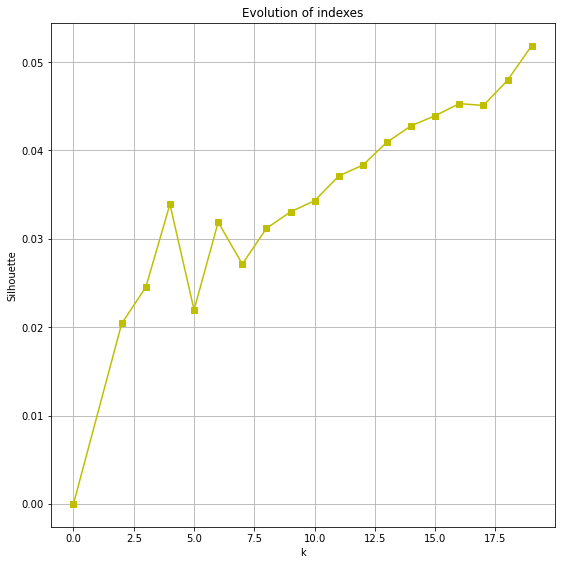

In [ ]:
# Code for kl evaluation
min_k = ...
max_k = ...

Sil=np.zeros(max_k)
x_axis=np.zeros(max_k)
tfidf_DTM_20news_norm = Normalizer().transform(tfidf_DTM_20news)

for m in range (min_k, max_k) :

    model = KMeans(n_clusters=m, max_iter=100, n_init=1, init="k-means++", random_state=3).fit(tfidf_DTM_20news_norm)

    # assign a cluster to each example
    labels = model.predict(tfidf_DTM_20news_norm)

    Sil[m]=silhouette_score(tfidf_DTM_20news_norm, labels, metric="cosine")
    x_axis[m]=m

fig = plt.figure(figsize=(7, 7))
a1 = fig.add_axes([0,0,1,1])
l1 = a1.plot(x_axis, Sil,'ys-') # solid line with yellow colour and square marker
a1.set_xlabel('k')
a1.set_ylabel('Silhouette')
a1.set_title('Evolution of indexes')
a1.yaxis.grid(True)
a1.xaxis.grid(True)
plt.show()

### <font color = 'E3A440'> b. Run clustering with k fixed </font>
Run the final clustering with a specific number of clusters, that you have chosen by analyzing the previous graph.

For consistency with the number of themes in the database, first try with `n_cluster=3`.

Fill in the three dots `...`

In [ ]:
tfidf_DTM_20news_norm = Normalizer().transform(tfidf_DTM_20news.toarray())
model = KMeans(n_clusters = ..., max_iter=200, n_init=1, init="k-means++", random_state=1).fit(tfidf_DTM_20news_norm)
# assign a cluster to each example
labels = model.predict(tfidf_DTM_20news_norm)

print("Silhouette=", silhouette_score(tfidf_DTM_20news_norm, labels, metric="cosine"))

Silhouette= 0.03393709837276581


In [ ]:
model.n_clusters

4

In [ ]:
Counter(model.labels_)

Counter({2: 867, 1: 1433, 3: 606, 0: 73})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2979 samples in 0.002s...
[t-SNE] Computed neighbors for 2979 samples in 0.477s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2979
[t-SNE] Computed conditional probabilities for sample 2000 / 2979
[t-SNE] Computed conditional probabilities for sample 2979 / 2979
[t-SNE] Mean sigma: 0.295911
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.360779
[t-SNE] KL divergence after 1000 iterations: 1.668502
t-SNE done! Time elapsed: 10.489466190338135 seconds


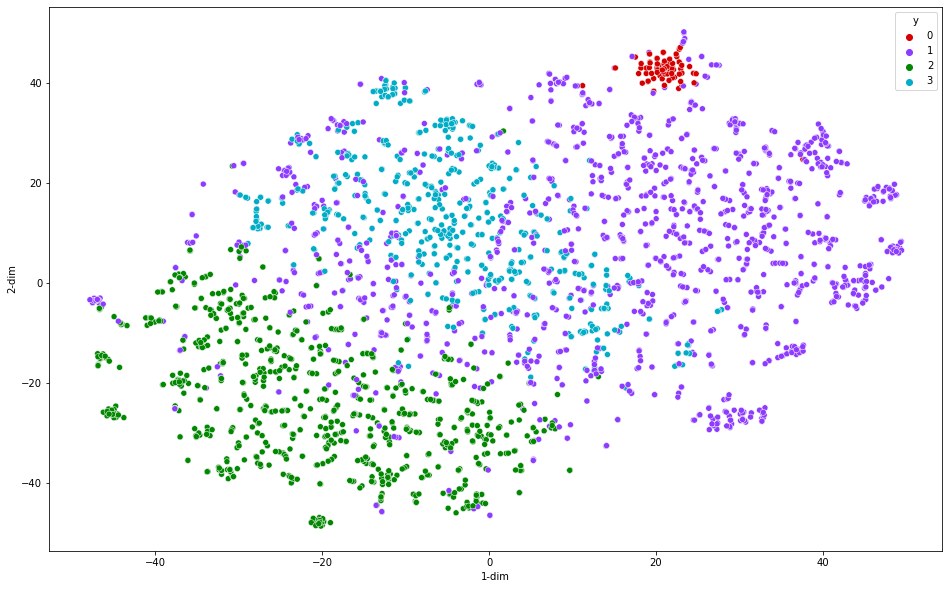

In [ ]:
tfidf_DTM_20news_norm = Normalizer().transform(tfidf_DTM_20news.toarray())
plot_data_by_cluster(tfidf_DTM_20news_norm, model )

### <font color = 'E3A440'> c. Look at the clustering results</font>

In [ ]:
from wordcloud import WordCloud
wordcloud_par_cluster(wordcloud = WordCloud(), # WordCloud function. 
                      DTM = tfidf_DTM_20news_norm,# Document-Term Matrix 
                      cls_kmeans = model, # Insert the result of a kmeans clustering
                      vocab = vectorized.vocabulary_, # a vocabulary from scikitlearn vectorizer
                      first_n_words=10,#  It indicates how many words to print
                      figsize=(12, 10),
                      fontsize=32,
                      plot_wordcloud = False, # Switch to True if you want to plot wordclouds
                      lst_clust = [], # Insert a list of integer to get info about a selected number of cluster. It shows info of all the clustrs if empty list
                      title_in_plot = "Clust_")

Most frequent words for cluster 0 of size 73 docs:  ['geb', 'bank', 'geb gordon', 'geb gordon bank', 'gordon bank', 'gordon', 'chastity intellect geb', 'gordon bank subject', 'intellect geb', 'bank n3jxp']
Most frequent words for cluster 1 of size 1433 docs:  ['distribution', 'people', 'doctor', 'anyone', 'problem', 'food', 'information', 'thanks', 'line article', 'effect']
Most frequent words for cluster 2 of size 867 docs:  ['game', 'team', 'player', 'hockey', 'nhl', 'espn', 'playoff', 'fan', 'year', 'goal']
Most frequent words for cluster 3 of size 606 docs:  ['car', 'engine', 'oil', 'dealer', 'price', 'ford', 'model', 'speed', 'time', 'mustang']


### <font color = 'E3A440'> d. Evaluate the generated partition with the starting targets of the 20 newsgroup dataset</font>
The objective of the next chunck of code is to modify the starting labels of the data, which are in the variable `target`, in order to make them coincide with the labels given by the algorithm.

Thus, if a segmentation into 3 clusters has been generated, it will be necessary:

 1. Interpret the results and identify which cluster corresponds to which `target` label.
 2. Change the labels and make them match the `target`,
 
<font color='E3A440'><bold>For example, if the three-cluster segmentation shows us that cluster `0` looks like subject `rec.autos`, identified with the value `7` in the `target` column , then we need to substitute all `7` with `0`. </bold></font>

Here are the labels of the 3 groups:
 1. `rec.autos`, identified with the value `7` in the `target` column
 2. `rec.sport.hockey`, identified with the value `10` in the `target` column
 3. `sci.med`, identified with the value `13` in the `target` column

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
df['target_converted'] = df.target
df['target_converted'] = df.target_converted.apply(lambda x: 0 if x == 7 else x)
df['target_converted'] = df.target_converted.apply(lambda x: 1 if x == 10 else x)
df['target_converted'] = df.target_converted.apply(lambda x: 2 if x == 13 else x)
print(accuracy_score(df.target_converted, model.labels_))

0.044310171198388724


Are you able to improve the evaluation metric (`accuracy`) by modifying the inputs of the model? For example, adding bigrams and trigrams?

## <font color = 'E3A440'>5.3 Supervised method : objective of the exercise </font>

1. Train a multilayer perceptron to classify documents by subject.


### <font color = 'E3A440'> a. Classify messages into target from original dataset</font>
In the next chunck of code, a supervised model is generated to recognize documents that are part of one of the following tags:

 1. `rec.autos`, identified with the value `7` in the `target` column
 2. `rec.sport.hockey`, identified with the value `10` in the `target` column
 3. `sci.med`, identified with the value `13` in the `target` column

To do this, a training corpus (`X_train`) with a list of labels that correspond to each document (`y_train`) and a test corpus (`X_test` accompanied by `y_test`) are built.

The training corpus (`X_train`) will be used to train a multilayer perceptron to classify documents with the correct label. The test corpus `X_test`, will be used to evaluate the performance of the model.

The `train_test_split()` function is used to create these corpora, and the `test_size` argument determines how much of the corpus will make up the text corpus (`X_test`).

In [ ]:
from sklearn.model_selection import train_test_split
tfidf_DTM_20news_norm = Normalizer().transform(tfidf_DTM_20news)
X_train, X_test, y_train, y_test = train_test_split(tfidf_DTM_20news_norm, df.target, test_size = 0.2,  random_state=1)

Here are the document counts in the training and test corpora.

In [ ]:
print(X_train.shape)
print(len(y_train))

(2383, 2989)
2383


In [ ]:
print(X_test.shape)
print(len(y_test))

(596, 2989)
596


### <font color = 'E3A440'> b. Training of the model </font>

With the `MLPClassifier()` function, a multilayer perceptron is built for the classification of documents into the selected labels.

Add the correct variables in the `MLPClassifier()` function to train the neural network.

Fill in the empty portions of code `...`.

Get inspired by section `4.1.2.` of this script.

In [ ]:
cls = MLPClassifier(random_state=1, max_iter=300).fit(..., ...)

### <font color = 'E3A440'> c. Validation of learning performance</font>

In the next chunck of code, the test corpus (`X_test`) is used to evaluate the model.



Add the right variables to generate the `y_valid`, which allows to evaluate the learing error rate and the `y_pred`, which allows to evaluate the prediction errors rate.

Fill in the empty portions of code `...`.

Take inspiration from section `4.1.3.` of this script.



In [ ]:
y_valid = cls.predict(...)
y_pred = cls.predict(...)

In [ ]:
print("Learning errors")
print("    Accurary = ", accuracy_score(y_train, y_valid)*100)

print("\nPrediction errors")
print("    Accurary = ", accuracy_score(y_test, y_pred)*100)

In [ ]:
print(confusion_matrix(y_test, y_pred))

# <font color = 'E3A440'> 6. Conclusion </font>

In this workshop, you learned how to manipulate text data for semantic analysis. You have been able to experience the impacts of preprocessing on the results of learning algorithms.
